In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from tqdm import tqdm 

import numpy as np
import pandas as pd
np.random.seed(seed=666)


import librosa
import librosa.display

from audiovocana.conf import *
from audiovocana.dataset import get_dataset
from audiovocana.preprocessing import (
    get_dataframe,
    get_audio_path
)
from audiovocana.color import dec
import audiovocana.ffmpeg_utils.ffmpeg_utils as ffmpeg

import matplotlib.pyplot as plt

~~~~~~ AUDIOVOCANA SETTINGS ~~~~~~
AUDIOPARAMS 
 {'sr': 250000, 'mono': True}
STFTPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'win_length': 8192, 'center': True, 'window': 'hann'}
SPECTRALCENTROIDPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None}
SPECTRALBANDWIDTHPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None, 'centroid': None, 'norm': True, 'p': 2}
SPECTRALFLATNESSPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'amin': 1e-10, 'power': 2.0}
ZEROCRPARAMS 
 {'frame_length': 2048, 'hop_length': 512, 'center': True}
MELPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'n_mels': 128, 'fmin': 0, 'fmax': 125000.0, 'htk': True}
MFCCPAMARS 
 {'sr': 250000, 'n_mfcc': 13, 'dct_type': 2, 'norm': 'ortho', 'htk': True}
mel fiterbank shape = (128, 4097)
Minimun waveform length accepted is 4104 PCM points.
Minimun audio duration accepted is 16.416 miliseconds.
STFT time resolution = 32.768 ms.
STFT frequency resolution = 30.5101293629485 Hz.


In [3]:
plt.style.use('ggplot')
MARKER = '.'
MARKERSIZE = 4
LINESTYLE ='-'
FONTSIZE = 12
FIGSIZE = (12, 8 )

kwargs = {'marker': MARKER, 'linestyle': 'solid', 'linewidth': 1, 'markersize': MARKERSIZE}


CSV_PATH = '/home/utilisateur/Desktop/palomars/data/full/dataset.csv'
CACHE_FOLDER = '/home/utilisateur/Desktop/palomars/cache/full_dataset'
AUDIO_FOLDER = "/media/utilisateur/LACIE SHARE/paloma-USV-data/audio"
RESULTS_FOLDER = "/home/utilisateur/Desktop/palomars/usv-experiments/full-dataset/results"

       
YEAR = 19
FILTERS = {'vocalization': 1, 'year': YEAR}

RESULTS_FOLDER = os.path.join(
    RESULTS_FOLDER,
    '_'.join([f"{k}:{v}" for k, v in FILTERS.items()]),
    'clustering'
)

CLUSTERS_FOLDER = os.path.join(
    RESULTS_FOLDER,
    'cluster_assigns'
)

In [4]:
get_dataframe(csv_path=CSV_PATH).head()

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings


,t0,t1,duration,event,postnatalday,vocalization,nest,year,audio_path,experiment,recording,mother
0,12.5711,12.6146,0.0435,1,1,1,E3,19,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1,62,E
1,12.7518,12.8204,0.0686,2,1,2,E3,19,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1,62,E
2,13.0119,13.0539,0.0420,3,1,2,E3,19,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1,62,E
3,13.1061,13.1425,0.0364,4,1,2,E3,19,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1,62,E
4,13.6437,13.6627,0.0190,5,1,2,E3,19,/media/utilisateur/LACIE SHARE/paloma-USV-data...,19N3EP1,62,E


In [5]:
dataset = get_dataset(
    csv_path=CSV_PATH,
    cache_folder=CACHE_FOLDER,
    shuffle=False,
    recompute=False
)

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings


In [6]:
keys =  [
    'audio_path',
    'vocalization',
    'mother',
    'year',
    'nest',
    'event',
    'postnatalday',
    'recording',
    'sbw',
    'sc',
    'sf',
    'zcr',
    't0',
    't1',
    'duration',
    'experiment'
]
df = pd.DataFrame.from_records([
    {k: dec(sample[k].numpy()) for k in keys}
    for sample in dataset
]).rename({
    'sbw': 'spectral_band_width',
    'sc': 'spectral_centroid',
    'sf': 'spectral_flatness',
    'zcr': 'zero_crossing_rate'
}, axis=1)

df.head()

,audio_path,vocalization,mother,year,nest,event,postnatalday,recording,spectral_band_width,spectral_centroid,spectral_flatness,zero_crossing_rate,t0,t1,duration,experiment
0,/media/utilisateur/LACIE SHARE/paloma-USV-data...,2,E,19,E3,9,1,62,"[22246.254, 21658.748, 20783.6, 19846.701, 190...","[67464.96, 67575.36, 67687.64, 67743.07, 67729...","[0.0015760899, 0.0021767751, 0.0025147777, 0.0...","[0.26757812, 0.4091797, 0.55078125, 0.56689453...",14.3595,14.3856,0.0261,19N3EP1
1,/media/utilisateur/LACIE SHARE/paloma-USV-data...,2,E,19,E3,11,1,62,"[35678.49, 35616.312, 35474.76, 35280.59, 3495...","[62235.566, 62107.277, 61951.2, 61886.81, 6206...","[0.15048917, 0.21641453, 0.26368162, 0.2933205...","[0.28027344, 0.43066406, 0.58203125, 0.5839844...",16.4044,16.4295,0.0251,19N3EP1
2,/media/utilisateur/LACIE SHARE/paloma-USV-data...,2,E,19,E3,5,1,62,"[29264.379, 28757.69, 28038.348, 27357.188, 26...","[62119.043, 62210.656, 62305.3, 62330.934, 622...","[0.01475213, 0.022314848, 0.027876219, 0.03040...","[0.2548828, 0.39160156, 0.52783203, 0.5449219,...",13.6437,13.6627,0.0190,19N3EP1
3,/media/utilisateur/LACIE SHARE/paloma-USV-data...,1,E,19,E3,14,1,62,"[25088.43, 25083.15, 25069.854, 25109.252, 252...","[22310.998, 22260.68, 22132.43, 22000.639, 218...","[0.0030751019, 0.0044109207, 0.0055570835, 0.0...","[0.049804688, 0.07324219, 0.09667969, 0.092285...",23.9093,23.9482,0.0389,19N3EP1
4,/media/utilisateur/LACIE SHARE/paloma-USV-data...,2,E,19,E3,8,1,62,"[22740.611, 22990.285, 23331.785, 23630.238, 2...","[64813.598, 64659.332, 64399.3, 64095.855, 638...","[0.003151348, 0.004623777, 0.0060713785, 0.007...","[0.26416016, 0.39892578, 0.5336914, 0.53515625...",14.1414,14.1634,0.0220,19N3EP1


**FFTPARAMS for figures**

In [7]:
HOP_LENGTH = 8
WIN_LENGTH = 200
NFFT = 200

SPECTRALCENTROIDPARAMS = {
    'sr': SR,
    'n_fft': NFFT,
    'hop_length': HOPLENGTH,
    'freq': None,
}

FFTPLOTPARAMS = {
    # for x axis settings
    'sr': SR,
    'hop_length': HOP_LENGTH,
    'x_axis': 'time',
    # for y axis settings
    'fmax': FMAX,
    'y_axis': 'linear',
    # color
    'cmap': 'bone', # 'gray', 'PuBu_r', 'RdBu',
    'vmin': -25,  # -50, -25
    'vmax': 0
}

FFTPARAMS = {
    'n_fft': NFFT,
    'hop_length': HOP_LENGTH,
    'win_length': WIN_LENGTH,
    'center': True,
    'pad_mode': 'reflect',
    'window': 'hann'
}


NBFFTBINS = 1 + FFTPARAMS['n_fft'] / 2

In [8]:
def plot_stft(row):
    
    y, sr = ffmpeg.load_audio_file(
                    audio_filename=row.audio_path,
                    start_second=row.t0, #  - 0.02,
                    duration_second=row.duration, # + 0.02
    )


    D = np.abs(librosa.stft(y.flatten(), **FFTPARAMS))

    fig = plt.figure(figsize=(10, 6))                         
    ax = librosa.display.specshow(librosa.power_to_db(D, ref=np.max), **FFTPLOTPARAMS)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Experiment {row.experiment} - Recording {row.recording} - Event {row.event}')
    plt.tight_layout()

    return fig

**compare features harmonic vs USV examples**

In [19]:
def compare_feats(rows):

    fig, axes = plt.subplots(6, len(rows), figsize=(16, 18), sharey='row')

    for i, row in enumerate(rows):
    

        y, sr = ffmpeg.load_audio_file(
                            audio_filename=row.audio_path,
                            start_second=row.t0, #  - 0.02,
                            duration_second=row.duration, # + 0.02
        )
        y = y.flatten()


        ax = axes[0, i]
        D = np.abs(librosa.stft(y, **FFTPARAMS))
        librosa.display.specshow(librosa.power_to_db(D, ref=np.max), ax=ax, **FFTPLOTPARAMS)
        ax.set(title=f'c{i+1} log Power spectrogram')

        ax = axes[5, i]
        f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=SR, fmin=12, fmax=FMAX, frame_length=2048)
        x = np.nan_to_num(f0, copy=False, nan=0.0)
        times = librosa.times_like(f0)    
        ax.plot(librosa.times_like(x), x, label='f0', color='c', marker='o')
        ax.legend(loc='upper left')
        ax.set(title=f'max {np.max(x)}')
        
        ax = axes[2, i]
        x = row.spectral_centroid
        ax.plot(librosa.times_like(x), x.T, label='spectral_centroid', color='r', marker='o')
        ax.legend(loc='upper left')
        ax.set(title=f'mean {np.mean(x)}')

        ax = axes[3, i]
        x = row.spectral_band_width
        ax.plot(librosa.times_like(x), x.T, label='spectral_band_width', color='y', marker='o')
        ax.legend(loc='upper left')
        ax.set(title=f'mean {np.mean(x)}')

        ax = axes[4, i]
        x = row.spectral_flatness
        ax.plot(librosa.times_like(x), x.T, label='spectral_flatness', color='g', marker='o')
        ax.legend(loc='upper left')
        ax.set(title=f'mean {np.mean(x)}')

        ax = axes[1, i] 
        x = row.zero_crossing_rate
        ax.plot(librosa.times_like(x), x.T, label='zero_crossing_rate', color='b', marker='o')
        ax.legend(loc='upper left')
        ax.set(title=f'mean {np.mean(x)}')
    
    
    plt.tight_layout(h_pad=1.5)

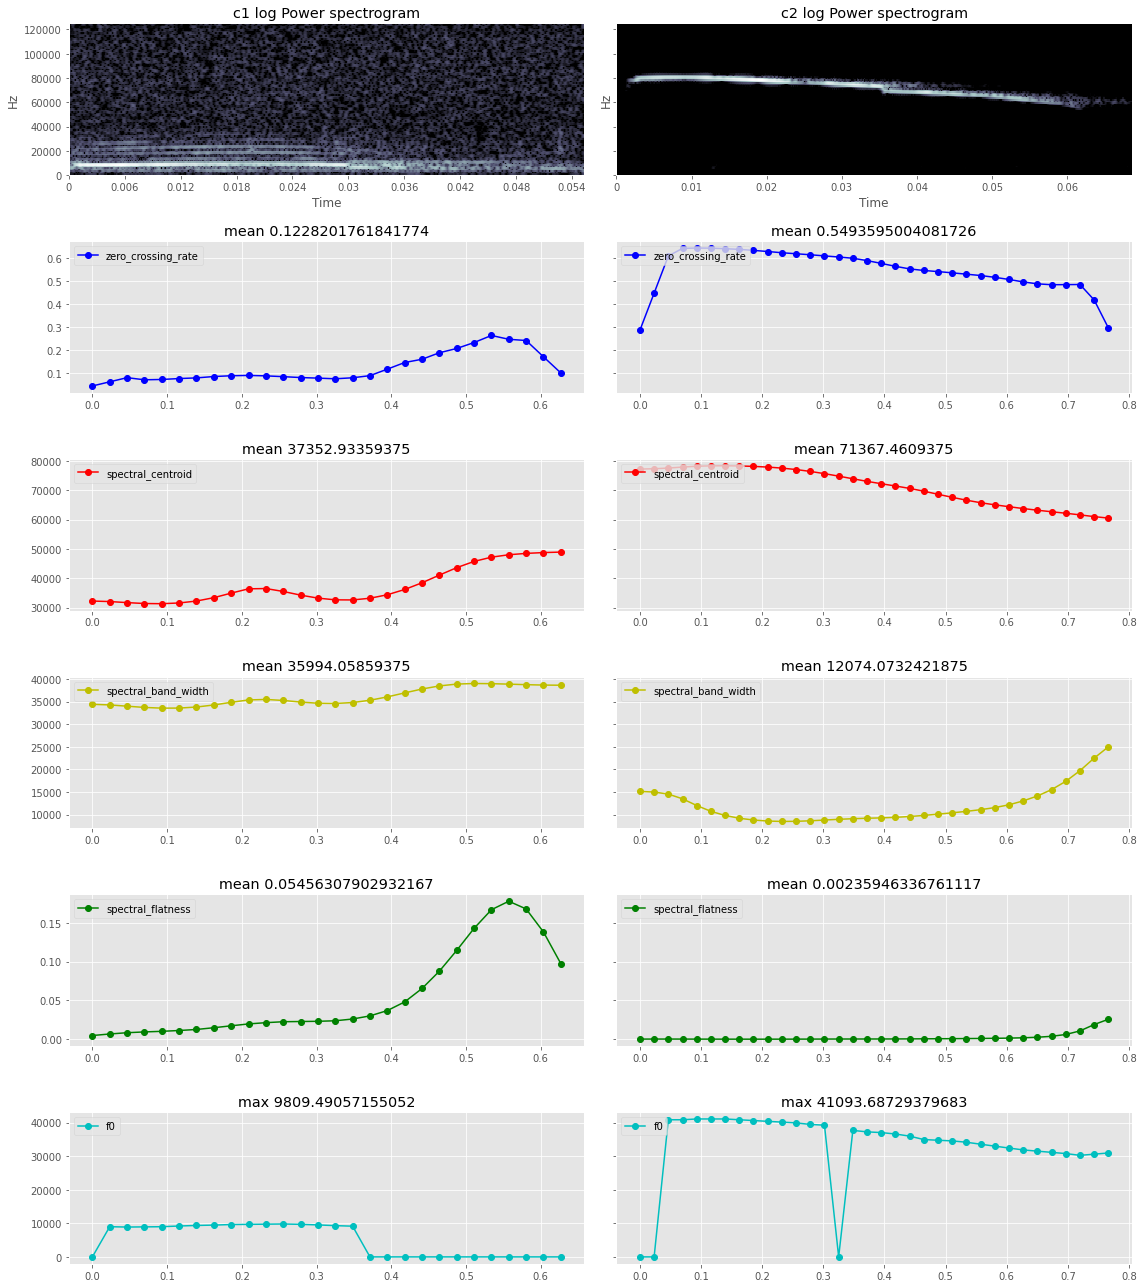

In [20]:
rows = [
    next(df[df.apply(lambda r: r.recording == 82 and r.event == 3, axis=1)].iterrows())[1],
    next(df[df.apply(lambda r: r.recording == 62 and r.event == 2, axis=1)].iterrows())[1],
]

compare_feats(rows)

## Compute spectrograms and save in folders by clustering

**Retrieve Clustering**

In [11]:
cluster_assigns = pd.read_csv(os.path.join(CLUSTERS_FOLDER, "mean_stft-ward-euclidean.csv"))
cluster_assigns.head()

,vocalization,mother,year,nest,postnatalday,event,recording,clust2,clust3,clust4,clust5,clust6,clust7,clust8
0,1,E,19,E3,1,14,62,2,3,4,5,6,7,8
1,1,E,19,E3,1,13,62,2,2,3,3,3,4,4
2,1,E,19,E3,1,15,62,2,3,4,5,6,7,8
3,1,E,19,E3,1,19,62,1,1,1,1,1,1,1
4,1,E,19,E3,1,21,62,2,3,4,4,5,6,6


In [12]:
cluster_assigns = pd.read_csv(os.path.join(CLUSTERS_FOLDER, "mean_stft-ward-euclidean.csv"))

MERGE_COLUMNS = ['mother', 'vocalization', 'year', 'nest', 'postnatalday', 'event', 'recording']
clustering = pd.merge(cluster_assigns, df, on=MERGE_COLUMNS, how='inner')
clustering.head()

,vocalization,mother,year,nest,postnatalday,event,recording,clust2,clust3,clust4,...,clust8,audio_path,spectral_band_width,spectral_centroid,spectral_flatness,zero_crossing_rate,t0,t1,duration,experiment
0,1,E,19,E3,1,14,62,2,3,4,...,8,/media/utilisateur/LACIE SHARE/paloma-USV-data...,"[25088.43, 25083.15, 25069.854, 25109.252, 252...","[22310.998, 22260.68, 22132.43, 22000.639, 218...","[0.0030751019, 0.0044109207, 0.0055570835, 0.0...","[0.049804688, 0.07324219, 0.09667969, 0.092285...",23.9093,23.9482,0.0389,19N3EP1
1,1,E,19,E3,1,13,62,2,2,3,...,4,/media/utilisateur/LACIE SHARE/paloma-USV-data...,"[23613.455, 23421.213, 23178.605, 22932.322, 2...","[23997.46, 23726.488, 23447.25, 23142.262, 227...","[0.0051144194, 0.00777397, 0.009496757, 0.0096...","[0.053222656, 0.0859375, 0.115234375, 0.122070...",20.9484,20.9966,0.0482,19N3EP1
2,1,E,19,E3,1,15,62,2,3,4,...,8,/media/utilisateur/LACIE SHARE/paloma-USV-data...,"[28833.84, 28217.291, 27242.568, 26333.797, 25...","[23057.46, 22386.064, 21436.611, 20665.06, 201...","[0.004720578, 0.006230526, 0.006235059, 0.0056...","[0.096191406, 0.114746094, 0.12988281, 0.07421...",39.9948,40.0455,0.0507,19N3EP1
3,1,E,19,E3,1,19,62,1,1,1,...,1,/media/utilisateur/LACIE SHARE/paloma-USV-data...,"[36534.01, 36213.1, 35659.793, 35039.55, 34446...","[35643.867, 34856.65, 33593.734, 32271.408, 31...","[0.030666938, 0.0426695, 0.045337737, 0.041531...","[0.10058594, 0.1274414, 0.15820312, 0.10986328...",285.1194,285.1978,0.0784,19N3EP1
4,1,E,19,E3,1,21,62,2,3,4,...,6,/media/utilisateur/LACIE SHARE/paloma-USV-data...,"[25570.254, 25461.926, 25197.64, 24833.244, 24...","[21263.918, 21192.732, 21062.25, 21006.113, 21...","[0.003617534, 0.0050111, 0.005510226, 0.005103...","[0.049804688, 0.07373047, 0.091308594, 0.07958...",291.6879,291.7422,0.0543,19N3EP1


In [13]:
rows = [r for idx, r in clustering.iterrows()]
for row in tqdm(rows[1:2]):

    fig = plot_stft(row)
    
    for n in range(2, 9):
        folder = os.path.join(RESULTS_FOLDER, "fft_images", f"clust{n}", str(row[f'clust{n}']))
        os.makedirs(folder, exist_ok=True)    
        figname = os.path.join(folder, f"{row.experiment}_r{row.recording}_e{row.event}.png")
        fig.savefig(os.path.join(folder, figname))

    plt.close(fig)

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


In [14]:
print("FIN ! ")

FIN ! 


## Compare 1d features by clustering

{'vocalization': 1, 'year': 19}
1: 220
2: 328
3: 50
4: 407


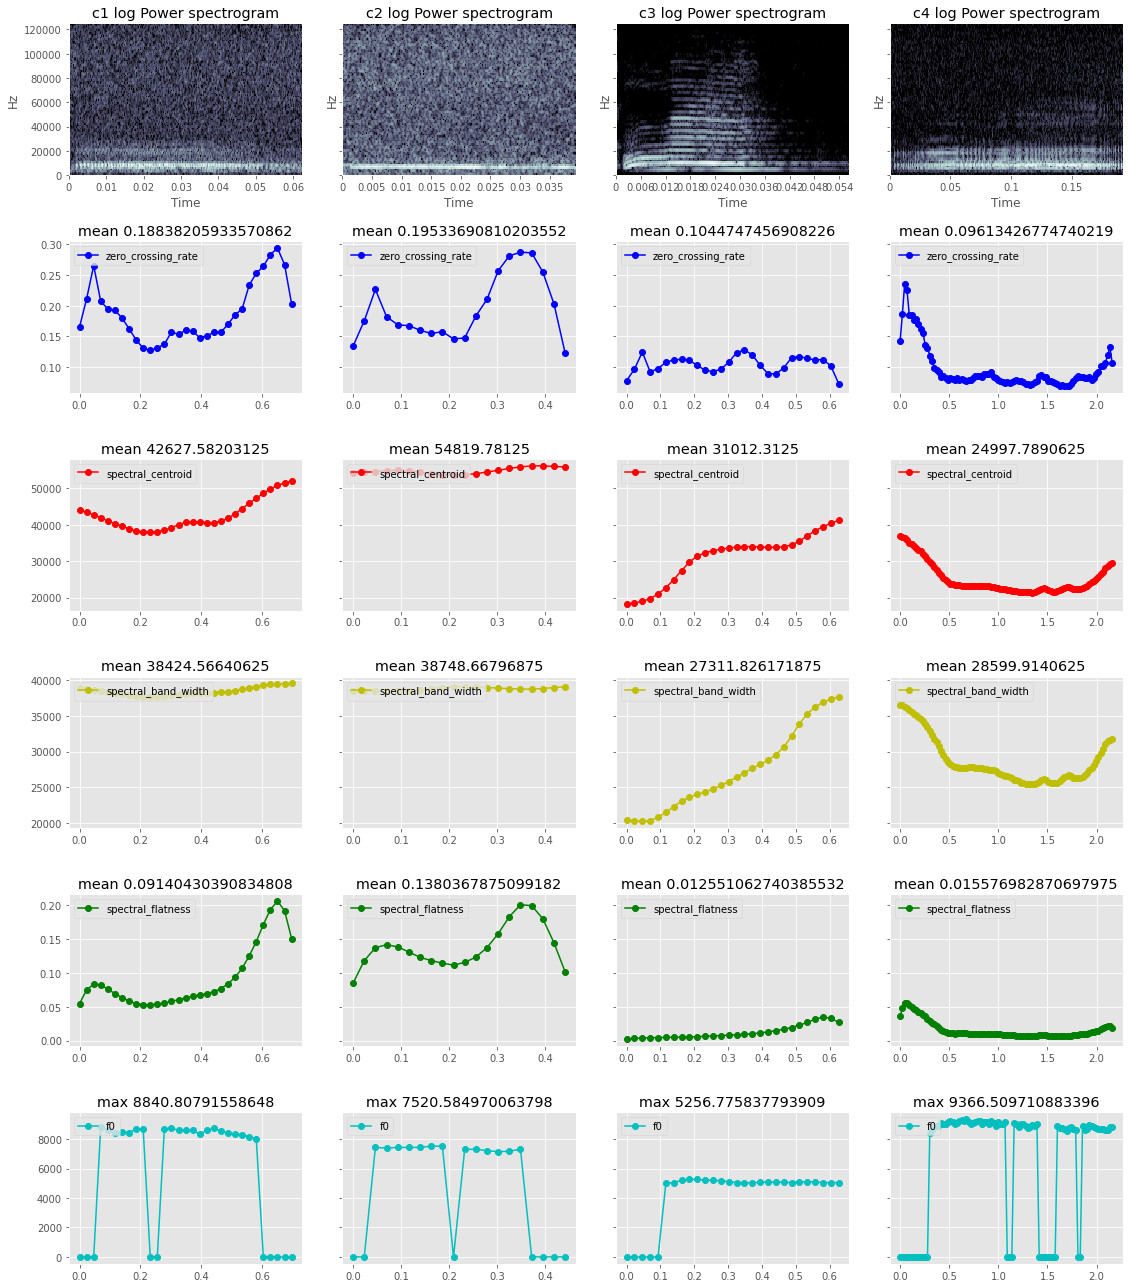

In [22]:
num_clusters = 4

ints = iter(np.random.randint(41, size=num_clusters))

d4 = {
    c :  [r for idx, r in clustering[clustering[f'clust{num_clusters}'] == c].iterrows()]
    for c in range(1, 5)
}

print(FILTERS)
for c in range(1, 5):
    print(f"{c}: {len(d4[c])}")
    
    
rows_to_compare = [d4[c][next(ints)] for c in range(1, num_clusters+1)]
compare_feats(rows_to_compare)
